# part0: imports

In [1]:
%matplotlib inline

from tqdm import tqdm
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import wilcoxon, mannwhitneyu, linregress


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection

import torch

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import lstm
        reload(lstm)
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    %run "fig2.ipynb"

    print('Done')

Done


# Part 1

functions that plot each panel.

---

Raster panel

In [2]:
def prep_example_df():
    raster_example = monkey_defs.raster_example
    raster_example_df = []
    for session in raster_example:
        path = root/session.split('_')[0]/session
        df = monkey_defs.prep_general(dt.load_pyal_data(path))
        df = pyal.restrict_to_interval(df, epoch_fun=monkey_defs.exec_epoch)
        raster_example_df.append(df)
    return raster_example_df

@utility.report
def plot_moneky_fr_raster(df,gs):
    trial=12
    axes = []
    data = []

    #example trial data for each target
    for tar in range(monkey_defs.n_targets):
        df_ = pyal.select_trials(df, df.target_id==tar)
        data.append(df_.M1_rates[trial])
    data = np.array(data)
    vmin = np.amin(data, axis= (0,1))
    vmax = np.amax(data, axis= (0,1))

    for j,tarData in enumerate(data):
        ax = fig.add_subplot(gs[j])
        axes.append(ax)
        tarData -= vmin
        tarData /= (vmax - vmin)
        ax.imshow(tarData.T, aspect='auto')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_title(r'$ \rightarrow $', rotation=(360/monkey_defs.n_targets)*(j-3), pad=0.5)
    axes[0].set_ylabel(f'Units ($n={tarData.shape[1]}$)')
    return axes

@utility.report
def plot_moneky_vel_ex(df,gs):
    trial=12
    axes = []
    for tar in range(monkey_defs.n_targets):
        df_ = pyal.select_trials(df, df.target_id==tar)
        data = df_.pos[trial]
        data -= np.mean(data, axis=0, keepdims=True)
        ax = fig.add_subplot(gs[tar])
        axes.append(ax)
        ax.plot(data[:,0], color='b', label='$X$')
        # ax2 = ax.twinx()
        # utility.phantom_axes(ax2)
        ax.plot(data[:,1], color='r', label='$Y$')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    return axes

In [7]:
raster_example_df = prep_example_df()
raster_example_df[0].head()

,monkey,date,task,target_direction,trial_id,result,bin_size,perturbation,perturbation_info,epoch,...,M1_spikes,M1_unit_guide,PMd_spikes,PMd_unit_guide,target_id,session,MCx_spikes,M1_rates,PMd_rates,MCx_rates
0,Chewie,10-13-2016,CO,-1.570796,1,R,0.03,FF,"[0.15, -1.48]",BL,...,"[[0.0, 1.0, 0.0, 1.4142135623730951, 0.0, 0.0,...","[[4, 1], [7, 1], [7, 2], [7, 3], [9, 1], [9, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [1, 2], [6, 1], [6, 3], [7, 1], [7, 2...",1,Chewie:10-13-2016,"[[0.0, 1.0, 0.0, 1.4142135623730951, 0.0, 0.0,...","[[21.993416, 30.248722, 6.6914177, 10.82206, 4...","[[0.003973114, 5.321711, 0.0, 2.594328, 0.0, 0...","[[21.993416, 30.248722, 6.6914177, 10.82206, 4..."
1,Chewie,10-13-2016,CO,3.141593,2,R,0.03,FF,"[0.15, -1.48]",BL,...,"[[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[[4, 1], [7, 1], [7, 2], [7, 3], [9, 1], [9, 2...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [1, 2], [6, 1], [6, 3], [7, 1], [7, 2...",7,Chewie:10-13-2016,"[[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[[34.64907, 0.87967294, 6.268801, 19.359598, 1...","[[8.541889, 0.0, 2.590355, 2.9540064, 0.0, 5.3...","[[34.64907, 0.87967294, 6.268801, 19.359598, 1..."
2,Chewie,10-13-2016,CO,-2.356194,3,R,0.03,FF,"[0.15, -1.48]",BL,...,"[[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0,...","[[4, 1], [7, 1], [7, 2], [7, 3], [9, 1], [9, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [1, 2], [6, 1], [6, 3], [7, 1], [7, 2...",0,Chewie:10-13-2016,"[[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0,...","[[33.95564, 19.885986, 20.282995, 0.034451418,...","[[0.42081097, 0.003973114, 2.625126, 13.829469...","[[33.95564, 19.885986, 20.282995, 0.034451418,..."
3,Chewie,10-13-2016,CO,2.356194,6,R,0.03,FF,"[0.15, -1.48]",BL,...,"[[1.4142135623730951, 1.0, 0.0, 0.0, 0.0, 1.0,...","[[4, 1], [7, 1], [7, 2], [7, 3], [9, 1], [9, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [1, 2], [6, 1], [6, 3], [7, 1], [7, 2...",6,Chewie:10-13-2016,"[[1.4142135623730951, 1.0, 0.0, 0.0, 0.0, 1.0,...","[[35.600994, 15.752223, 10.763535, 13.829149, ...","[[0.034451418, 0.00031967516, 0.0, 7.631738, 0...","[[35.600994, 15.752223, 10.763535, 13.829149, ..."
4,Chewie,10-13-2016,CO,-2.356194,7,R,0.03,FF,"[0.15, -1.48]",BL,...,"[[1.0, 1.0, 0.0, 0.0, 1.0, 1.7320508075688772,...","[[4, 1], [7, 1], [7, 2], [7, 3], [9, 1], [9, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [1, 2], [6, 1], [6, 3], [7, 1], [7, 2...",0,Chewie:10-13-2016,"[[1.0, 1.0, 0.0, 0.0, 1.0, 1.7320508075688772,...","[[27.85547, 21.753119, 10.161446, 7.627765, 29...","[[3.474001, 7.631738, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[27.85547, 21.753119, 10.161446, 7.627765, 29..."


3D dynamics panel

In [3]:
@utility.report
def plot_monkey_pc_example(raster_example_df, gs):   
    fig=gs.figure
    
    colors = utility.get_colors(8)
    dfs=[]
    axes=[]
    for i,df in enumerate(raster_example_df):
        rates = np.concatenate(df['M1_rates'].values, axis=0)
        rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
        df_ = pyal.apply_dim_reduce_model(df, rates_model, 'M1_rates', '_pca');
        dfs.append(df_)
        ax = fig.add_subplot(gs[i], projection='3d',fc='None')
        axes.append(ax)
        for tar in range(monkey_defs.n_targets):
            df__ = pyal.select_trials(df_, df_.target_id==tar)
            ex = pyal.get_sig_by_trial(df__,'_pca')
            ex = np.mean(ex, axis=2)[:,:3]
            ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
            ax.view_init(60,-47)

    AllData = dt.get_data_array(raster_example_df, area='M1', model=10)
    data1 = np.reshape(AllData[0,...], (-1,10))
    data2 = np.reshape(AllData[1,...], (-1,10))
    A,B,*_ = dt.canoncorr(data1,data2,fullReturn=True)
    coef_ = [A,B]
    for i,sessionData in enumerate(AllData):
        ax = fig.add_subplot(gs[i+3], projection='3d',fc='None')
        U, _, Vh = linalg.svd(coef_[i], full_matrices=False, compute_uv=True, overwrite_a=False, check_finite=False)
        axes.append(ax)
        for tar in range(8):
            ex = np.mean(sessionData[tar,...], axis=0)
            ex = ex @ U @ Vh
            ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
            ax.view_init(60,-47)

    titles=[r'Monkey $C_L$ (\textit{unaligned})',r'Monkey $M$ (\textit{unaligned})',
            r'Monkey $C_L$ (\textit{aligned})',  r'Monkey $M$ (\textit{aligned})']
    labels = ['PC','PC','CC','CC']
    for i, ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel(f'{labels[i]}1', labelpad=-15)
        ax.set_ylabel(f'{labels[i]}2', labelpad=-15)
        ax.set_zlabel(f'{labels[i]}3', labelpad=-15)
        ax.set_title(titles[i], y=.9, loc='center')
    
    #======== add the arrow
    
    ax = fig.add_subplot(gs[2], fc='None')
    ax = utility.phantom_axes(ax)
    ax.arrow(0,0,1,0,length_includes_head=True, width=.005, head_width=.015,head_length=.1, ec='k', fc='k')
    ax.set_ylim([-.1,.1])
    ax.set_xlim([-.5,1.1])
    ax.text(0.5,0.01,'CCA', ha='center', va='bottom')
    ax.text(0.5,-0.01,'(alignment)', ha='center', va='top')
    
    return axes

CCA for the example sessions

In [4]:
@utility.report
def plot_cca_for_ex(ax,):
    defs = monkey_defs
    raster_example = defs.raster_example
    raster_example_df = []
    for session in raster_example:
        path = root/session.split('_')[0]/session
        df = defs.prep_general(dt.load_pyal_data(path))
        raster_example_df.append(df)
    
    df1, df2 = raster_example_df
    AllData1 = dt.get_data_array(df1, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    AllData2 = dt.get_data_array(df2, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T
    
    # lower bound
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))
    AllDataL1 = defs._get_data_array(df1, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    AllDataL2 = defs._get_data_array(df2, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllDataL1.shape,AllDataL2.shape),axis=0)
    CCsL=[]
    for sessionData1,sessionData2 in zip(AllDataL1,AllDataL2):
        r = []
        for n in range(params.n_iter * 10):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T
    
    # upper bound
    AllDataU = dt.get_data_array([df1,df2], monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    n_shared_trial1 = AllDataU.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for session, sessionData in enumerate(AllDataU):
        r = []
        for n in range(params.n_iter * 10):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,monkey_defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,monkey_defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # plotting
    x_ = np.arange(1,monkey_defs.n_components+1)
    ax.plot(x_, allCCs, color=params.colors.MainCC, marker = 'o', label=f'Across monkeys')
    ax.plot(x_, CCsU[:,0], color=params.colors.UpperCC, marker = '<', ls='--', label=f'Within monkey1')
    ax.plot(x_, CCsU[:,1], marker = '<', ls='--', label=f'Within monkey2')
    ax.plot(x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':', label=f'Control')


    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,monkey_defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax.set_title(f'{defs.areas[2]} Alignment')
    ax.legend(loc=(.55,.67))
    ax.set_ylabel('Canonical correlation')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,monkey_defs.n_components])
    ax.spines['left'].set_bounds([0,1])

Executed: `plot_cca_for_ex` in 3.7s


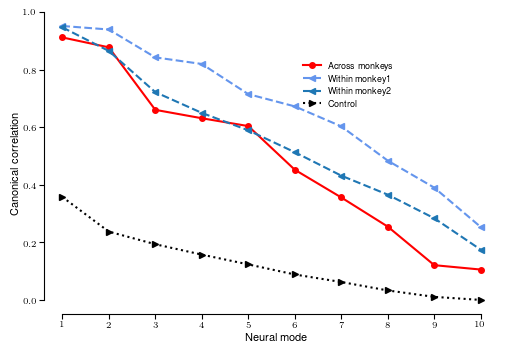

In [5]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig,ax = plt.subplots(dpi=100)
    
    plot_cca_for_ex(ax)
    

---

monkey population CCA plot

In [6]:
@utility.report
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

In [7]:
@utility.report
def plot_monkey_cca(ax, ax_hist, full_list_MCx, allDFs_MCx):
    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]
    AllData1 = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData2 = dt.get_data_array(side2df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    # lower bound
    len_trial = int(np.round(np.diff(monkey_defs.WINDOW_exec)/monkey_defs.BIN_SIZE))
    single_FileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            single_FileList1.append((I,J))
    n_iter = params.n_iter * 10
    side1df = [allDFs_MCx[i] for i,_ in single_FileList1]
    side2df = [allDFs_MCx[j] for _,j in single_FileList1]
    AllData1 = monkey_defs._get_data_array(side1df, epoch_L=len_trial, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData1_ = monkey_defs._get_data_array(side2df, epoch_L=len_trial, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData1_.shape),axis=0)

    CCsL=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData1_):
        r = []
        for n in range(n_iter):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)

            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T

    # Upper bound
    single_FileList1 = []
    for I, _ in enumerate(full_list_MCx):
        single_FileList1.append(I)
    side1df = [allDFs_MCx[i] for i in single_FileList1]
    AllData1 = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for session, sessionData in enumerate(AllData1):
        r = []
        for n in range(n_iter):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # plotting
    x_ = np.arange(1,monkey_defs.n_components+1)
    utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC, marker = 'o')
    utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC, marker = '<', ls='--')
    utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':')

    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,monkey_defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Canonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,monkey_defs.n_components])
    ax.spines['left'].set_bounds([0,1])
    ax.text(x=monkey_defs.n_components, y=1, s= f'$n={CCsL.shape[1]}$ pairs of sessions\nacross $3$ monkeys',
           ha='right', va='top', fontsize=mpl.rcParams['xtick.labelsize'])
    
    #plot the hist

    bins = np.arange(0,1,0.05)
    ax_hist.xaxis.set_visible(False)
    ax_hist.set_facecolor('None')
    ax_hist.spines['bottom'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['left'].set_bounds([0,1])
    ax_hist.set_ylim([-.05,1])
    ax_hist.hist(allCCs[:4,:].mean(axis=0), bins=bins, density=True, label=f'Across ($n={allCCs.shape[1]}$)',
            color=params.colors.MainCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsU[:4,:].mean(axis=0), bins=bins, density=True,label=f'Within ($n={CCsU.shape[1]}$)',
            color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsL[:4,:].mean(axis=0), bins=bins, density=True, label=f'Control ($n={CCsL.shape[1]}$)',
            color=params.colors.LowerCC, alpha=.8, orientation='horizontal')

    ax_hist.tick_params('y', direction='out')
    ax_hist.set_yticklabels([])
    ax_hist.legend(loc=(0,-.05))

    #stats ###################################
    allCCs_median = np.median(allCCs[:4,:].mean(axis=0))
    CCsU_median = np.median(CCsU[:4,:].mean(axis=0))
    CCsL_median = np.median(CCsL[:4,:].mean(axis=0))
    allCCs_mean = allCCs[:4,:].mean(axis=0)
    CCsU_mean = CCsU[:4,:].mean(axis=0)
    CCsL_mean = CCsL[:4,:].mean(axis=0)

    #calc stats
    ##for paired stats
    side1CCsU_mean = [CCsU_mean[i] for i,_ in pairFileList1]
    side2CCsU_mean = [CCsU_mean[j] for _,j in pairFileList1]
    allCCsU_mean = side1CCsU_mean + side2CCsU_mean
        
    compare_upper_stats = wilcoxon(np.tile(allCCs_mean,2), allCCsU_mean)
    compare_lower_stats = wilcoxon(allCCs_mean, CCsL_mean)

    ##for unpaired stats
    # compare_upper_stats = mannwhitneyu(allCCs_mean, CCsU_mean)
    # compare_lower_stats = mannwhitneyu(allCCs_mean, CCsL_mean)

    print("Across vs within:", compare_upper_stats)
    print("Across vs control:", compare_lower_stats)

    if params.annotate_stats:
        #annotate stats
        xmin, xmax = ax_hist.get_xlim()
        markerx = xmax+(xmax-xmin)*0.05
        linex = xmax+(xmax-xmin)*0.15
        textx = xmax+(xmax-xmin)*0.25
        line_kwargs = dict(linewidth = 0.5, color = 'k')
        text_kwargs = dict(ha='left', va='center')

        ax_hist.scatter(markerx, allCCs_median, color = params.colors.MainCC, marker = '<')
        ax_hist.scatter(markerx, CCsU_median, color = params.colors.UpperCC, marker = '<')
        ax_hist.scatter(markerx, CCsL_median, color = params.colors.LowerCC, marker = '<')

        ax_hist.plot([linex, linex], [allCCs_median, CCsU_median], **line_kwargs)
        ax_hist.plot([linex, linex], [allCCs_median, CCsL_median], linestyle = '--', **line_kwargs)
        
        ax_hist.text(textx, (allCCs_median + CCsU_median)/2, dt.get_signif_annot(compare_upper_stats[1]), **text_kwargs)
        ax_hist.text(textx, (allCCs_median + CCsL_median)/2, dt.get_signif_annot(compare_lower_stats[1]), **text_kwargs)


Executed: `get_full_monkey_data` in 14.4s
Across vs within: WilcoxonResult(statistic=0.0, pvalue=0.125)
Across vs control: WilcoxonResult(statistic=0.0, pvalue=0.5)
Executed: `plot_monkey_cca` in 6.2s


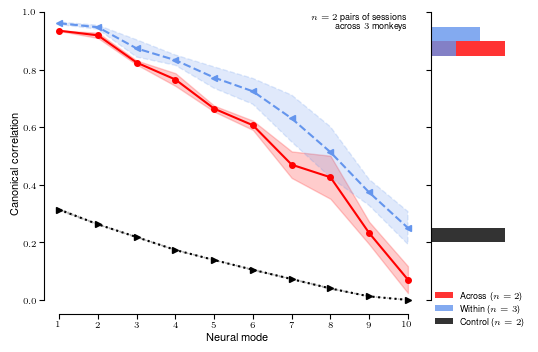

In [8]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

    ax = fig.add_subplot(gs[0])
    ax_ = fig.add_subplot(gs[1])

    
    full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca(ax,ax_, full_list_MCx[10:13], allDFs_MCx)
    
    plt.show()

---

decoding for monkeys

In [9]:
@utility.report

def plot_monkey_decoding(ax, allDFs, redo = False):
    defs = monkey_defs

    within_score = {}
    aligned_score = {}
    unaligned_score = {}
    for i, df1 in enumerate(tqdm(allDFs)):
        pathPickle = root / 'monkey-pickles' / f'{df1.session[0]}_within.p'

        if os.path.exists(pathPickle) and not redo:
            with open(pathPickle,"rb") as f:
                within_score[df1.session[0]] = pickle.load(f)
        else:
            AllData, AllVel = defs.get_data_array_and_vel([df1], defs.exec_epoch_decode,
                                                        area=defs.areas[2], n_components=defs.n_components)
            # adding history
            AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
            AllData = AllData[...,defs.MAX_HISTORY:,:]
            AllVel = AllVel[...,defs.MAX_HISTORY:,:]
            AllData1 = AllData[0,...]
            AllVel1 = AllVel[0,...]
            *_,n_time,n_comp = AllData1.shape
            # resizing
            X1 = AllData1.reshape((-1,n_time,n_comp))
            AllVel1 = AllVel1.reshape((-1,n_time,2))
            
            fold_score =[]
            kf = KFold(n_splits=10)
            for train_index, test_index in kf.split(X1[:,0,0]):
                x_train, x_test = X1[train_index,...], X1[test_index,...]
                y_train, y_test = AllVel1[train_index,...], AllVel1[test_index,...]

                lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=2)
                lstm_model.fit(x_train=x_train, y_train=y_train)
                lstm_model.predict(x_test, y_test)
                fold_score.append(lstm_model.score)
            fold_score = np.median(fold_score)
            within_score[df1.session[0]] = fold_score

            with open(pathPickle, 'wb') as f:
                pickle.dump(within_score[df1.session[0]], f)
                f.close()

        aligned_score[df1.session[0]] = {}
        unaligned_score[df1.session[0]] = {}
        for j, df2 in enumerate(tqdm(allDFs)):
            if j <= i: continue
            if df1.monkey[0] == df2.monkey[0]: continue
            if 'Chewie' in df1.monkey[0] and 'Chewie' in df2.monkey[0]: continue
            alignedPickle = root / 'monkey-pickles' /  f'{df1.session[0]}-{df2.session[0]}_aligned.p'
            unalignedPickle = root / 'monkey-pickles' /  f'{df1.session[0]}-{df2.session[0]}_unaligned.p'
            if os.path.exists(alignedPickle) and os.path.exists(unalignedPickle) and not redo:
                with open(alignedPickle,"rb") as f:
                    aligned_score[df1.session[0]][df2.session[0]] = pickle.load(f)
                    f.close()
                with open(unalignedPickle,"rb") as f:
                    unaligned_score[df1.session[0]][df2.session[0]] = pickle.load(f)
                    f.close()
            else:

                AllData, AllVel = defs.get_data_array_and_vel([df1,df2],
                                                            defs.exec_epoch_decode, area=defs.areas[2], n_components=defs.n_components)
                # adding history
                AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
                AllData = AllData[...,defs.MAX_HISTORY:,:]
                AllVel = AllVel[...,defs.MAX_HISTORY:,:]

                AllData1 = AllData[0,...]
                AllData2 = AllData[1,...]
                AllVel1 = AllVel[0,...]
                AllVel2 = AllVel[1,...]
                # resizing
                *_,n_time,n_comp = AllData1.shape

                X1 = AllData1.reshape((-1,n_comp))
                X2 = AllData2.reshape((-1,n_comp))
                AllVel2 = AllVel2.reshape((-1,n_time,2))
                AllVel1 = AllVel1.reshape((-1,n_time,2))

                # train the aligned
                *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
                U = U.reshape((-1,n_time,n_comp))
                V = V.reshape((-1,n_time,n_comp))
                X1 = X1.reshape((-1,n_time,n_comp))
                X2 = X2.reshape((-1,n_time,n_comp))

                lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=2)
                lstm_model.fit(x_train=U, y_train=AllVel1)
                lstm_model.predict(V, AllVel2)
                aligned_score[df1.session[0]][df2.session[0]]=lstm_model.score.mean()
                with open(alignedPickle, 'wb') as f:
                    pickle.dump(lstm_model.score.mean(), f)
                    f.close()
                #================================
                # Unaligned
                lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=2)
                lstm_model.fit(x_train=X1, y_train=AllVel1)
                lstm_model.predict(X2, AllVel2)
                unaligned_score[df1.session[0]][df2.session[0]]=lstm_model.score.mean()
                with open(unalignedPickle, 'wb') as f:
                    pickle.dump(lstm_model.score.mean(), f)
                    f.close()

#======================== PLOTTING
    pop_within = np.array(list(within_score.values()))
    pop_aligned = np.array([val for key in aligned_score for val in aligned_score[key].values()])
    pop_unaligned = np.array([val for key in unaligned_score for val in unaligned_score[key].values()])

    ax.errorbar(1, pop_aligned.mean(), np.std(pop_aligned), label='Across\n' r'(\textit{aligned})',
                color=params.colors.MainCC, fmt='-o', capsize=1.5)    
    ax.errorbar(0, pop_unaligned.mean(), np.std(pop_unaligned), label='Across\n' r'(\textit{unaligned})',
                color=params.colors.LowerCC, fmt='-o', capsize=1.5)
    ax.errorbar(2, pop_within.mean(), np.std(pop_within), label='Within',
                color=params.colors.UpperCC, fmt='-o', capsize=1.5)

    unal_vals = []
    al_vals = []
    wi_vals = []
    for file1, nested_dict in aligned_score.items():
        wi_val1 = within_score[file1]
        for file2, al_val in nested_dict.items():
            wi_val2 = within_score[file2]
            unal_val = unaligned_score[file1][file2]
            ax.plot([0,1,2], [unal_val, al_val, wi_val1],
                    color='gray', lw=.2, zorder=6, marker = 'o', ms=.1, alpha=.2)
            ax.plot([1,2], [al_val, wi_val2],
                    color='gray', lw=.2, zorder=6, marker = 'o', ms=.1, alpha=.2)

            #for stats
            unal_vals.append(unal_val)
            al_vals.append(al_val)
            wi_vals.append(wi_val1)
            wi_vals.append(wi_val2)
    
    ax.set_xlim([-0.2,2.2])
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['Across\n' r'(\textit{unaligned})',
                        'Across\n' r'(\textit{aligned})',
                        'Within'])
    ax.set_ylabel('Prediction accuracy ($R^2$)')
    ax.set_ylim([-.05,1])
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([0,2])
    ax.spines['left'].set_bounds([0,1])

    #stats ########################################
    #calc stats
    ##for paired stats
    compare_upper_stats = wilcoxon(np.repeat(al_vals,2), wi_vals)
    compare_lower_stats = wilcoxon(al_vals, unal_vals)

    print("Across vs within:", compare_upper_stats)
    print("Across vs control:", compare_lower_stats)

    #annotate stats
    if params.annotate_stats:
        ymin, ymax = ax.get_ylim()
        liney = ymax*0.95
        texty = ymax*1
        line_kwargs = dict(linewidth = 0.5, color = 'k')
        text_kwargs = dict(ha='left', va='center')

        ax.plot([0,1], [liney, liney], **line_kwargs)
        ax.plot([1,2], [liney, liney], linestyle = '--', **line_kwargs)
        
        ax.text(0.5, texty, dt.get_signif_annot(compare_upper_stats[1]), **text_kwargs)
        ax.text(1.5, texty, dt.get_signif_annot(compare_lower_stats[1]), **text_kwargs)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 7227.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 12449.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 12841.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 13000.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 12991.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/

Across vs within: WilcoxonResult(statistic=9068.0, pvalue=2.988135480998934e-09)
Across vs control: WilcoxonResult(statistic=0.0, pvalue=2.029467500049271e-22)
Executed: `plot_monkey_decoding` in 0.1s


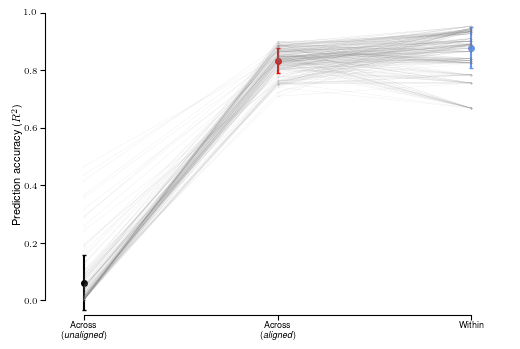

In [10]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()

    # _, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_decoding(ax, allDFs_MCx, redo=False)
    plt.show()

---

Mouse CCA plot

In [11]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

In [12]:
@utility.report
def plot_mouse_cca(ax, ax_hist, allDFs_M1):
    defs = mouse_defs
    
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, (df2) in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]
    AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
    AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    # upper bound
    AllData1 = dt.get_data_array(allDFs_M1, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
    n_iter = params.n_iter * 10
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for sessionData in AllData1:
        r = []
        for n in range(n_iter):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # lower bound
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, df2 in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))

    AllData1 = dt.get_data_array(side1df, area=defs.areas[0], model=defs.n_components)
    AllData2 = dt.get_data_array(side2df, area=defs.areas[0], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)

    CCsL=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        r = []
        for n in range(n_iter):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            time_idx = params.rng.integers(min_time-len_trial)

            data1 = np.reshape(sessionData1_sh[:,:min_trials,time_idx:time_idx+len_trial,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,time_idx:time_idx+len_trial,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T


    #====================================PLOTTING
    
    x_ = np.arange(1,defs.n_components+1)
    utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC, marker = 'o')
    utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC, marker = '<', ls='--')
    utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':')

    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Canonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,defs.n_components])
    ax.spines['left'].set_bounds([0,1])
    ax.text(x=defs.n_components, y=1, s= f'$n={CCsL.shape[1]}$ pairs of sessions\nacross $4$ mice',
            ha='right', va='top', fontsize=mpl.rcParams['xtick.labelsize'])

    #plot the hist

    bins = np.arange(0,1,0.05)
    ax_hist.xaxis.set_visible(False)
    ax_hist.set_facecolor('None')
    ax_hist.spines['bottom'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['left'].set_bounds([0,1])
    ax_hist.set_ylim([-.05,1])
    ax_hist.hist(allCCs[:4,:].mean(axis=0), bins=bins, density=True, label=f'($n={allCCs.shape[1]}$)',
            color=params.colors.MainCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsU[:4,:].mean(axis=0), bins=bins, density=True,label=f'($n={CCsU.shape[1]}$)',
            color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsL[:4,:].mean(axis=0), bins=bins, density=True, label=f'($n={CCsL.shape[1]}$)',
            color=params.colors.LowerCC, alpha=.8, orientation='horizontal')
    
    ax_hist.tick_params('y', direction='out')
    ax_hist.set_yticklabels([])
    ax_hist.legend(loc=(0,-0.05))

    #stats ###########################
    allCCs_median = np.median(allCCs[:4,:].mean(axis=0))
    CCsU_median = np.median(CCsU[:4,:].mean(axis=0))
    CCsL_median = np.median(CCsL[:4,:].mean(axis=0))
    allCCs_mean = allCCs[:4,:].mean(axis=0)
    CCsU_mean = CCsU[:4,:].mean(axis=0)
    CCsL_mean = CCsL[:4,:].mean(axis=0)

    #calc stats
    ##for paired stats
    side1CCsU_mean = [CCsU_mean[i] for i,_ in pairFileList1]
    side2CCsU_mean = [CCsU_mean[j] for _,j in pairFileList1]
    allCCsU_mean = side1CCsU_mean + side2CCsU_mean
        
    compare_upper_stats = wilcoxon(np.tile(allCCs_mean,2), allCCsU_mean)
    compare_lower_stats = wilcoxon(allCCs_mean, CCsL_mean)

    ##for unpaired stats
    # compare_upper_stats = mannwhitneyu(allCCs_mean, CCsU_mean)
    # compare_lower_stats = mannwhitneyu(allCCs_mean, CCsL_mean)

    print("Across vs within:", compare_upper_stats)
    print("Across vs control:", compare_lower_stats)

    #annotate stats
    if params.annotate_stats:
        xmin, xmax = ax_hist.get_xlim()
        markerx = xmax+(xmax-xmin)*0.05
        linex = xmax+(xmax-xmin)*0.15
        textx = xmax+(xmax-xmin)*0.25
        line_kwargs = dict(linewidth = 0.5, color = 'k')
        text_kwargs = dict(ha='left', va='center')

        ax_hist.scatter(markerx, allCCs_median, color = params.colors.MainCC, marker = '<')
        ax_hist.scatter(markerx, CCsU_median, color = params.colors.UpperCC, marker = '<')
        ax_hist.scatter(markerx, CCsL_median, color = params.colors.LowerCC, marker = '<')

        ax_hist.plot([linex, linex], [allCCs_median, CCsU_median], **line_kwargs)
        ax_hist.plot([linex, linex], [allCCs_median, CCsL_median], linestyle = '--', **line_kwargs)
    
        ax_hist.text(textx, (allCCs_median + CCsU_median)/2, dt.get_signif_annot(compare_upper_stats[1]), **text_kwargs)
        ax_hist.text(textx, (allCCs_median + CCsL_median)/2, dt.get_signif_annot(compare_lower_stats[1]), **text_kwargs)


    

Executed: `get_full_mouse_data` in 0.8s
Across vs within: WilcoxonResult(statistic=0.0, pvalue=2.9802322387695312e-08)
Across vs control: WilcoxonResult(statistic=0.0, pvalue=0.000244140625)
Executed: `plot_mouse_cca` in 7.9s


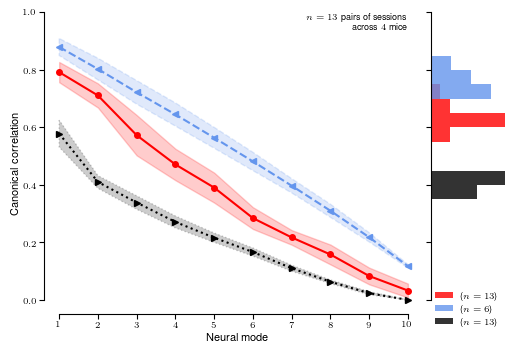

In [13]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

    ax = fig.add_subplot(gs[0])
    ax_ = fig.add_subplot(gs[1])

    
    allDFs_M1, _ = get_full_mouse_data()
    
    plot_mouse_cca(ax,ax_, allDFs_M1)
    
    plt.show()

---

plot the behavioural vs CCA

In [14]:
@utility.report
def plot_monkey_cca_corr(ax, allDFs_MCx):

    #get behavioral correlation for paired reaches
    try:
        os.chdir(params.repoPath / 'monkey')
        %run "_monkey-corr.ipynb"
    finally:
        os.chdir(NBPath)
    
    across_corrs_monkeys = trim_across_monkey_corr(allDFs_MCx)

    #get pairs of sessions
    pairFileList_monkeys = []
    for I, df1 in enumerate(allDFs_MCx):
        for J, df2 in enumerate(allDFs_MCx):
            if J<=I or df1.monkey[0] == df2.monkey[0]: continue  # to repetitions
            if 'Chewie' in df1.monkey[0] and 'Chewie' in df2.monkey[0]: continue
            pairFileList_monkeys.append((I,J))
    
    #get data for neural modes
    side1df = [allDFs_MCx[i] for i,_ in pairFileList_monkeys]
    side2df = [allDFs_MCx[j] for _,j in pairFileList_monkeys]
    AllData1_monkey = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData2_monkey = dt.get_data_array(side2df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials_monkey, min_time_monkey,_ = np.min((AllData1_monkey.shape,AllData2_monkey.shape),axis=0)

    CC_corr_monkey=[]
    #for each pair of sessions across monkeys
    for i, (sessionData1,sessionData2) in enumerate(zip(AllData1_monkey,AllData2_monkey)):
        data1 = np.reshape(sessionData1[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
        k,l = pairFileList_monkeys[i]

        #get behavioral correlation
        behav = np.array(across_corrs_monkeys[allDFs_MCx[k].session[0]][allDFs_MCx[l].session[0]])
        behav = behav[behav>params.Behav_corr_TH]

        #perform CCA
        CC_corr_monkey.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
    CC_corr_monkey = np.array(CC_corr_monkey)
    
    #plotting
    ax.scatter(CC_corr_monkey[:,1],CC_corr_monkey[:,0], color=params.colors.MonkeyPts, label='Monkeys', zorder=0)
    ax.set_xlabel('Behavioural correlation')
    ax.set_ylabel('Canonical correlation')
    ax.set_ylim([.53,.85])
    ax.spines['left'].set_bounds([.55,.85])
    ax.set_xlim([.69,.95])
    ax.spines['bottom'].set_bounds([.7,.95])
    ax.legend(loc=(0,.8))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_major_formatter(FormatStrFormatter('$%0.2f$'))

    return CC_corr_monkey[:,1], CC_corr_monkey[:,0]
    
@utility.report
def plot_mouse_cca_corr(ax, AllDFs):
    try:
        os.chdir(params.repoPath / 'mouse')
        %run "_mouse-corr.ipynb"
    finally:
        os.chdir(NBPath)
        
    across_corrs_mice = trim_across_mouse_corr (AllDFs)
    
    pairFileList_mice = []
    for I, df1 in enumerate(AllDFs):
        for J, (df2) in enumerate(AllDFs):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList_mice.append((I,J))

    side1df = [AllDFs[i] for i,_ in pairFileList_mice]
    side2df = [AllDFs[j] for _,j in pairFileList_mice]
    AllData1_mice = dt.get_data_array(side1df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=mouse_defs.n_components)
    AllData2_mice = dt.get_data_array(side2df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=mouse_defs.n_components)
    _,_, min_trials_mice, min_time_mice,_ = np.min((AllData1_mice.shape,AllData2_mice.shape),axis=0)

    CC_corr_mice=[]
    for i, (sessionData1,sessionData2) in enumerate(zip(AllData1_mice,AllData2_mice)):
        data1 = np.reshape(sessionData1[:,:min_trials_mice,:min_time_mice,:], (-1,mouse_defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials_mice,:min_time_mice,:], (-1,mouse_defs.n_components))
        k,l = pairFileList_mice[i]
        behav = np.array(across_corrs_mice[AllDFs[k].file[0]][AllDFs[l].file[0]])
        behav = behav[behav>params.Behav_corr_TH]
        CC_corr_mice.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
    CC_corr_mice = np.array(CC_corr_mice)

    #plotting
    ax.scatter(CC_corr_mice[:,1],CC_corr_mice[:,0],color=params.colors.MousePts, label='Mice', zorder=1)

    return CC_corr_mice[:,1],CC_corr_mice[:,0]

In [15]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()
    
    _, allDFs_MCx = get_full_monkey_data()
    allDFs_M1, _ = get_full_mouse_data()

    # plot_mouse_cca_corr(ax, allDFs_M1)
    # plot_monkey_cca_corr(ax, allDFs_MCx[10:15])
    mouse_behav, mouse_cc = plot_mouse_cca_corr(ax, allDFs_M1)
    monkey_behav, monkey_cc = plot_monkey_cca_corr(ax, allDFs_MCx[10:15])

    m, b, r_val, p_val, _ = linregress(mouse_behav, mouse_cc) 
    print('mouse only"', r_val, p_val)
    m, b, r_val, p_val, _ = linregress(monkey_behav, monkey_cc)
    print('monkey only"', r_val, p_val)
    m, b, r_val, p_val, _ = linregress(np.concatenate([mouse_behav, monkey_behav]), np.concatenate([mouse_cc, monkey_cc]))
    print('monkey and mouse"', r_val, p_val)
    
    # xmin, xmax = ax.get_xlim()
    # ax.plot([xmin,xmax], [m*xmin+b, m*xmax+b], color = 'grey') 
    plt.savefig('dummy.PDF')
    plt.show()


Executed: `get_full_monkey_data` in 14.2s
Executed: `get_full_mouse_data` in 0.8s
Executed: `plot_mouse_cca_corr` in 5.8s
Executed: `plot_monkey_cca_corr` in 5.8s
mouse only" 0.6699754802004876 0.01222885686156232
monkey only" 0.46645176525922055 0.35106699812241954
monkey and mouse" 0.882937219642739 5.569367358759387e-07


<Figure size 3600x2400 with 0 Axes>

---

plot the within session trajectory correlations

In [16]:
@utility.report
def plot_traj_corr(ax, allDFs_MCx, AllDFs):
    try:
        os.chdir(params.repoPath / 'monkey')
        %run "_monkey-corr.ipynb"
        os.chdir(params.repoPath / 'mouse')
        %run "_mouse-corr.ipynb"
    finally:
        os.chdir(NBPath)

    within_corrs_monkeys = trim_within_monkey_corr (allDFs_MCx)
    within_corrs_mice = trim_within_mouse_corr (AllDFs)

    # plotting
    
    w_mice = list(within_corrs_mice.values())
    w_mice = np.array([l for L in w_mice for l in L])
    w_monkey = list(within_corrs_monkeys.values())
    w_monkey = np.array([l for L in w_monkey for l in L])
    ax.hist(w_mice,   density=True,alpha=.8,color=params.colors.MousePts, label=r'Mice')
    ax.hist(w_monkey, density=True,alpha=.8,color=params.colors.MonkeyPts, label=r'Monkeys')
    ax.axvline(w_mice.mean(), color=params.colors.MousePts, zorder=0)
    ax.axvline(w_monkey.mean(), color=params.colors.MonkeyPts, zorder=0)
    
    ax.set_yticks([])
    ax.set_xticks([0,1])
    ax.set_xlim([0,1])
    ax.tick_params(axis='x', direction='in')
    ax.set_ylabel('Probability\ndensity')
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_facecolor('None')

In [17]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()
    
    # _, allDFs_MCx = get_full_monkey_data()
    # allDFs_M1, _ = get_full_mouse_data()

    plot_traj_corr(ax, allDFs_MCx[10:15], allDFs_M1)    
    
    plt.show()

Executed: `plot_traj_corr` in 1.0s


# Part 2
Plot figure

In [2]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    %matplotlib inline
    figsize=params.LargeFig
    fig=plt.figure(figsize=figsize)
    
   

    ##########################################
    # 1: schematics
    gs1   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0, 
                                    bottom=figsize[1]-params.panels.schmatic[1], 
                                    width=params.panels.schmatic[0], 
                                    height=params.panels.schmatic[1])
    ax1   =fig.add_subplot(gs1[0])
    ax1 = utility.phantom_axes(ax1)
    ax1.set_facecolor([0,0,0,0])


    ##########################################
    # 2: Raster
    gs2_1 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     left=params.panels.schmatic[0],
                                     bottom=figsize[1]-params.panels.schmatic[1]+params.panels.velocity[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.raster[1])
    gs2_2 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     right=figsize[0],
                                     top=figsize[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.raster[1])
    
    gs2_3 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     left=params.panels.schmatic[0],
                                     bottom=figsize[1]-params.panels.schmatic[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.velocity[1])
    gs2_4 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     right=figsize[0],
                                     top=figsize[1]-params.panels.raster[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.velocity[1])

    
    raster_example_df = prep_example_df()
    
    axes2_1 = plot_moneky_fr_raster(raster_example_df[0], gs2_1)
    axes2_2 = plot_moneky_fr_raster(raster_example_df[1], gs2_2)
    utility.phantom_axes(fig.add_subplot(gs2_1[:])).set_title('Monkey $C_L$', pad=8)
    utility.phantom_axes(fig.add_subplot(gs2_2[:])).set_title('Monkey $M$', pad=8)
    
    axes2_3 = plot_moneky_vel_ex(raster_example_df[0], gs2_3)
    axes2_4 = plot_moneky_vel_ex(raster_example_df[1], gs2_4)

    axes2_3[0].set_ylabel('Position\n(centred)')
    axes2_3[0].set_xlabel('Time relative to movement onset',loc='left')
    X_line = mlines.Line2D([], [], color='blue', label='$X$')
    Y_line = mlines.Line2D([], [], color='red', label='$Y$')
    axes2_4[-1].legend(handles=[X_line, Y_line], loc=(1.1,.1))
        
    gs2_c = utility.add_gridspec_abs(fig, nrows=1, ncols=1, 
                                     height=params.panels.raster[1]-.15, 
                                     width=.1, 
                                     left=figsize[0]+.2, 
                                     bottom=figsize[1]-params.panels.schmatic[1]+params.panels.velocity[1])
    cax2 = fig.add_subplot(gs2_c[:])
    fig.colorbar(cm.ScalarMappable(),cax=cax2, ticks=(0,1),drawedges=False)
    cax2.set_title('Normalised\nfiring rate')


    
    
    ##########################################
    # 3: 3D projections
    gs3   =utility.add_gridspec_abs(fig, nrows=1, ncols=5, left=0, 
                                    bottom=figsize[1]-params.panels.schmatic[1]-params.panels.proj_3d_align[1]-.3,
                                    width=params.panels.proj_3d_align[0], 
                                    height=params.panels.proj_3d_align[1])

    
    axes3 = plot_monkey_pc_example(raster_example_df, gs3)
    
    
    gs3_c = utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0,
                                    bottom=(axes3[0].get_position().y0+axes3[0].get_position().y1)/2*figsize[1],
                                    width=.2, height=0.2)
    cax3 = fig.add_subplot(gs3_c[0],zorder=10)

    utility.plot_targets(cax3,3)
    cax3.set_xlim(np.array(cax3.get_xlim())*1.15)
    cax3.set_ylim(np.array(cax3.get_ylim())*1.15)

    
    ##########################################
    # 4: CCA plot for the example animals
    gs4   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    left=0,
                                    bottom=gs3.bottom*figsize[1]-params.panels.cca[1]-.3, 
                                    width=params.panels.cca[0],
                                    height=params.panels.cca[1])

    ax4 = fig.add_subplot(gs4[0])
    
    plot_cca_for_ex(ax4)
    

    
    
    ##########################################
    # 5: CCA plot for population
    gs5 = fig.add_gridspec(nrows=1, ncols=2,  width_ratios=(params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]),
                           left=gs4.right+(.7/figsize[0]),  # .7" offset
                           right=gs4.right+ (.7/figsize[0]) + params.panels.cca_hist[0]/figsize[0],
                           bottom=gs4.bottom,
                           top=gs4.top,
                           wspace=0)

    ax5 = fig.add_subplot(gs5[0])
    ax5_ = fig.add_subplot(gs5[1])

    full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca(ax5,ax5_, full_list_MCx, allDFs_MCx)
    
    
    
    ##########################################
    # 6: Decoding for monkeys
    gs6   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    top=gs5.top*figsize[1],
                                    right=figsize[0],
                                    width=params.panels.decoding_hist[0],
                                    height=params.panels.decoding_hist[1])

    ax6 = fig.add_subplot(gs6[0])

       
    plot_monkey_decoding(ax6, allDFs_MCx, redo=False)

    
    
    ##########################################
    # 7: schematics Mouse
    gs7   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0, 
                                    bottom=gs6.bottom*figsize[1]-params.panels.schmatic[1],
                                    width=params.panels.schmatic[0],
                                    height=params.panels.cca[1])
    ax7   =fig.add_subplot(gs7[0])
    ax7 = utility.phantom_axes(ax7)
    ax7.set_facecolor([0,1,0,0])

    
    
    
    ##########################################
    # 8: CCA plot for MICE
    gs8 = fig.add_gridspec(nrows=1, ncols=2,  width_ratios=(params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]),
                           left=gs5.left,
                           right=gs5.right,
                           bottom=gs7.bottom,
                           top=gs7.top,
                           wspace=0)

    ax8 = fig.add_subplot(gs8[0])
    ax8_ = fig.add_subplot(gs8[1])
    
    
    allDFs_M1, _ = get_full_mouse_data()
    
    plot_mouse_cca(ax8,ax8_, allDFs_M1)
    
    
    
    ##########################################
    # 9: Behaviour vs CCA
    gs9   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    top=gs7.top*figsize[1],
                                    right=figsize[0],
                                    width=params.panels.neuro_behav_corr[0],
                                    height=params.panels.neuro_behav_corr[1])
    gs9_inset   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                                left=gs9.right*figsize[0]-.7,
                                                bottom=gs9.bottom*figsize[1]+.1,
                                                width=.7,
                                                height=params.panels.TinyH)
    ax9 = fig.add_subplot(gs9[0])
    ax9_ = fig.add_subplot(gs9_inset[0])


    
    mouse_behav, mouse_cc = plot_mouse_cca_corr(ax9, allDFs_M1)
    monkey_behav, monkey_cc = plot_monkey_cca_corr(ax9, allDFs_MCx)

    m, b, r_val, p_val, _ = linregress(mouse_behav, mouse_cc) 
    print('mouse only"', r_val, p_val)
    m, b, r_val, p_val, _ = linregress(monkey_behav, monkey_cc)
    print('monkey only"', r_val, p_val)
    m, b, r_val, p_val, _ = linregress(np.concatenate([mouse_behav, monkey_behav]), np.concatenate([mouse_cc, monkey_cc]))
    print('monkey and mouse"', r_val, p_val)

    plot_traj_corr(ax9_, allDFs_MCx, allDFs_M1)


    
    
#     fig.align_ylabels([ax1,ax4])
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    AXES=(ax1,axes2_1[0],axes3[0],ax4,ax5,ax6,ax7,ax8,ax9)
    OFFX=np.array([.02]*len(AXES))
    OFFY=np.array([.01]*len(AXES))
    # OFFX[[-1]]=0.12
    OFFX[[0,2,3,4,5,6,7,8]]=0.05
    
    params.add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)
    
    fig.savefig(params.figPath / 'figure2.pdf', format='pdf', bbox_inches='tight')
    

    ##########################################
    # monkey schematics
 
    thisPath  =str(params.figPath / 'figure2.pdf')
    sketchPath=str(params.figPath / 'monkey-task-schematic.pdf')
    if os.path.exists(sketchPath):
        f1=ppdf.PdfFileReader(thisPath).getPage(0)
        f2=ppdf.PdfFileReader(sketchPath).getPage(0)

        f1.mergeTranslatedPage(page2=f2, tx=10, ty=347, expand=False)

        writer=ppdf.PdfFileWriter()
        writer.addPage(f1)
        with open(thisPath,'wb') as f3:
            writer.write(f3)



    ##########################################
    # mouse schematics
            
    thisPath  =str(params.figPath / 'figure2.pdf')
    sketchPath=str(params.figPath / 'mouse-task-schematic.pdf')
    if os.path.exists(sketchPath):
        f1=ppdf.PdfFileReader(thisPath).getPage(0)
        f2=ppdf.PdfFileReader(sketchPath).getPage(0)

        f1.mergeTranslatedPage(page2=f2, tx=10, ty=20, expand=False)

        writer=ppdf.PdfFileWriter()
        writer.addPage(f1)
        with open(thisPath,'wb') as f3:
            writer.write(f3)

Executed: `plot_moneky_fr_raster` in 0.1s
Executed: `plot_moneky_fr_raster` in 0.1s
Executed: `plot_moneky_vel_ex` in 0.1s
Executed: `plot_moneky_vel_ex` in 0.1s
Executed: `plot_monkey_pc_example` in 0.2s
Executed: `plot_cca_for_ex` in 3.6s
Executed: `get_full_monkey_data` in 14.1s
Across vs within: WilcoxonResult(statistic=1.0, pvalue=4.406614147759508e-43)
Across vs control: WilcoxonResult(statistic=0.0, pvalue=2.029467500049271e-22)
Executed: `plot_monkey_cca` in 145.0s


100%|██████████| 21/21 [2:14:47<00:00, 385.11s/it]


Across vs within: WilcoxonResult(statistic=11098.0, pvalue=2.9202521695885326e-05)
Across vs control: WilcoxonResult(statistic=0.0, pvalue=2.029467500049271e-22)
Executed: `plot_monkey_decoding` in 8087.3s
Executed: `get_full_mouse_data` in 0.8s
Across vs within: WilcoxonResult(statistic=0.0, pvalue=2.9802322387695312e-08)
Across vs control: WilcoxonResult(statistic=0.0, pvalue=0.000244140625)
Executed: `plot_mouse_cca` in 7.6s
Executed: `plot_mouse_cca_corr` in 6.0s
Executed: `plot_monkey_cca_corr` in 58.7s
mouse only" 0.5895873583016745 0.03394765675190192
monkey only" -0.07789471007698524 0.38595839149759514
monkey and mouse" 0.6754535851988064 7.500232875276993e-20
Executed: `plot_traj_corr` in 1.1s
